In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [66]:
pd.set_option('display.width', 200) 

In [67]:
data = pd.read_csv('../data/exon_classification.csv')
print(data.head())
print(data.shape)

        geneName       name  chrom strand   txStart     txEnd  cdsStart    cdsEnd  exonCount                                         exonStarts                                           exonEnds  \
0  0610005C13Rik  NR_038165   chr7      -  45217218  45224600  45224600  45224600          4           [45217218, 45223836, 45224031, 45224550]           [45217803, 45223946, 45224201, 45224600]   
1  0610005C13Rik  NR_038166   chr7      -  45217218  45224600  45224600  45224600          5  [45217218, 45220409, 45223836, 45224031, 45224...  [45217803, 45220616, 45223946, 45224201, 45224...   
2  0610009B22Rik  NM_025319  chr11      -  51576211  51579461  51576473  51576896          2                               [51576211, 51579374]                               [51576919, 51579461]   
3  0610009E02Rik  NR_152208   chr2      +  26335935  26348007  26348007  26348007          2                               [26335935, 26347684]                               [26336212, 26348007]   
4  0610009

- 全ての遺伝子について、バリアント数の分布を可視化

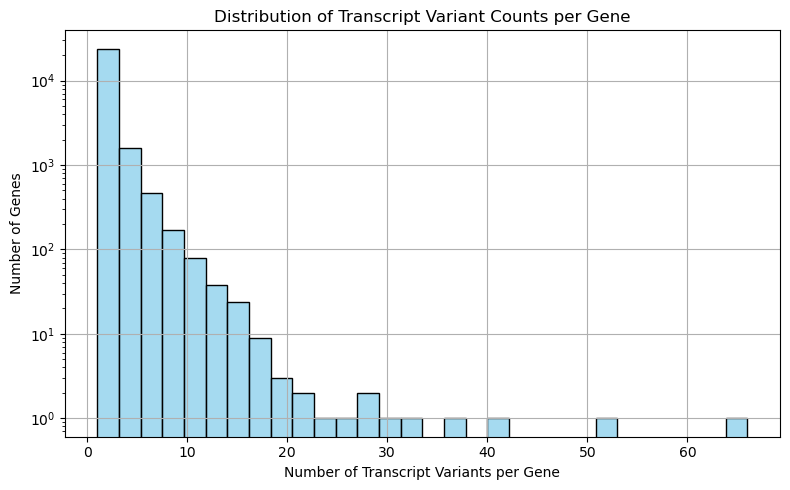

In [79]:
plt.figure(figsize=(8, 5))
sns.histplot(variant_counts["variant_count"], bins=30, kde=False, color="skyblue")

plt.xlabel("Number of Transcript Variants per Gene")
plt.ylabel("Number of Genes")
plt.title("Distribution of Transcript Variant Counts per Gene")
plt.grid(True)
plt.yscale('log')
plt.tight_layout()
plt.show()


- TOP5のvariant数を持つ遺伝子を見る

In [80]:
top_5_variant_counts = variant_counts.nlargest(5, "variant_count")
print(top_5_variant_counts)

      geneName  variant_count
4559     Celf4             66
2886    Arpp21             51
9682   Gm32817             40
15242     Mlip             36
3330      Bag6             33


- variant 数が最も多いcelf4の中身を確認する

In [81]:
print(data[data["geneName"] == "Celf4"].head(10))

     geneName          name  chrom strand   txStart     txEnd  cdsStart    cdsEnd  exonCount                                         exonStarts                                           exonEnds  \
7801    Celf4  NM_001362337  chr18      -  25610676  25812805  25619894  25670812         13  [25610676, 25619850, 25624197, 25629278, 25630...  [25612768, 25620022, 25624281, 25629362, 25630...   
7802    Celf4  NM_001146292  chr18      -  25610676  25887214  25619894  25886684         13  [25610676, 25619850, 25624137, 25629278, 25630...  [25612768, 25620022, 25624281, 25629359, 25630...   
7803    Celf4  NM_001146293  chr18      -  25610676  25887214  25619894  25886684         13  [25610676, 25619850, 25624197, 25629278, 25630...  [25612768, 25620022, 25624281, 25629359, 25630...   
7804    Celf4  NM_001146294  chr18      -  25610676  25887214  25619894  25886684         13  [25610676, 25619850, 25624137, 25629278, 25630...  [25612768, 25620022, 25624281, 25629362, 25630...   
7805    Ce

- 遺伝子当たりの最大or最小エキソン数のヒストグラムを描画する

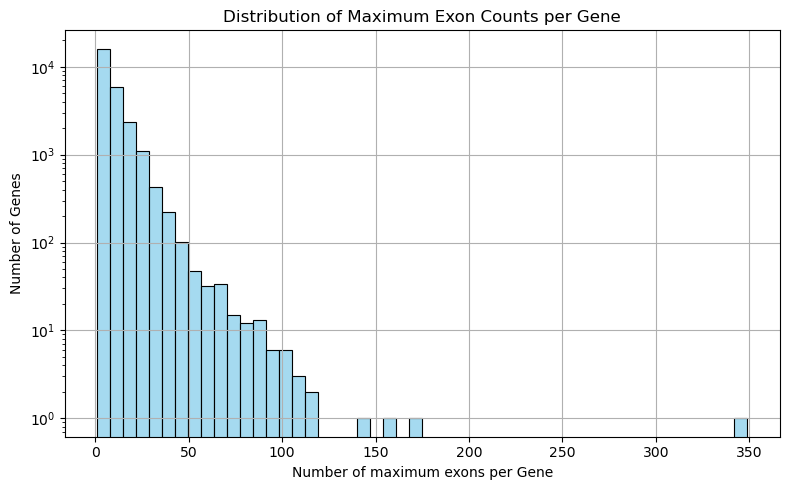

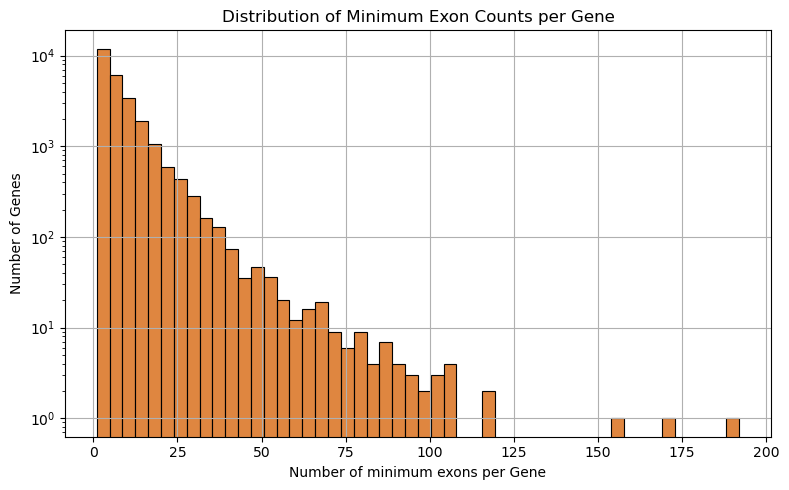

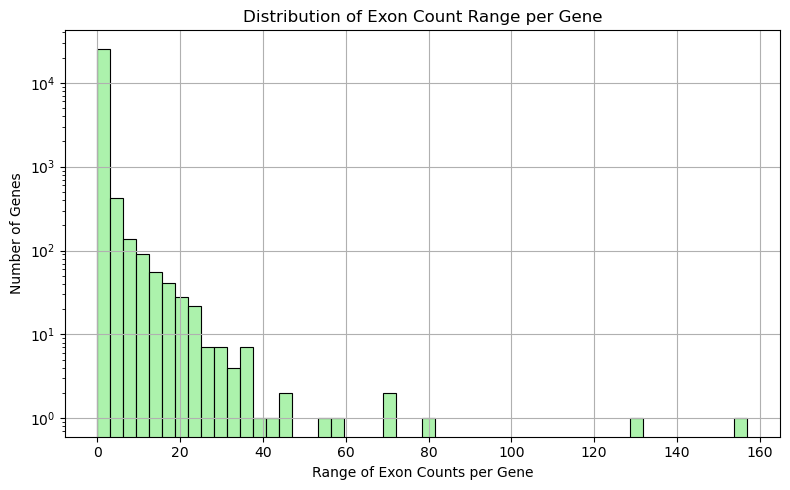

In [85]:
plt.figure(figsize= (8,5))
sns.histplot(maximum_exon_counts["max_exon_count"], bins=50, kde=False, color="skyblue")
plt.xlabel("Number of maximum exons per Gene")
plt.ylabel("Number of Genes")
plt.title("Distribution of Maximum Exon Counts per Gene")
plt.grid(True)
plt.yscale('log')
plt.tight_layout()
plt.show()

plt.figure(figsize= (8,5))
sns.histplot(minimum_exon_counts["min_exon_count"], bins=50, kde=False, color="#D55E00")
plt.xlabel("Number of minimum exons per Gene")
plt.ylabel("Number of Genes")
plt.title("Distribution of Minimum Exon Counts per Gene")
plt.grid(True)
plt.yscale('log')
plt.tight_layout()
plt.show()

range_exon_counts = maximum_exon_counts.merge(minimum_exon_counts, on="geneName", how="left")
range_exon_counts["exon_count_range"] = range_exon_counts["max_exon_count"] - range_exon_counts["min_exon_count"]
plt.figure(figsize=(8, 5))
sns.histplot(range_exon_counts["exon_count_range"], bins=50, kde=False, color="lightgreen")
plt.xlabel("Range of Exon Counts per Gene")
plt.ylabel("Number of Genes")
plt.title("Distribution of Exon Count Range per Gene")
plt.grid(True)
plt.yscale('log')
plt.tight_layout()
plt.show()

- エキソン数がtop5の遺伝子の中身を確認する

In [86]:
top_5_exon_counts = data.nlargest(5, "max_exon_count")
print(top_5_exon_counts)

      geneName          name chrom strand   txStart     txEnd  cdsStart    cdsEnd  exonCount                                         exonStarts                                           exonEnds  \
42464      Ttn     NM_011652  chr2      -  76534327  76812891  76535374  76810526        313  [76534327, 76536013, 76536783, 76537040, 76538...  [76535673, 76536316, 76536937, 76537732, 76538...   
42465      Ttn     NM_028004  chr2      -  76534327  76812891  76535374  76810526        192  [76534327, 76536013, 76536783, 76537040, 76538...  [76535673, 76536316, 76536937, 76537732, 76538...   
42466      Ttn  NM_001385708  chr2      -  76534325  76812890  76535374  76810526        349  [76534325, 76536013, 76536783, 76537040, 76538...  [76535673, 76536316, 76536937, 76537732, 76538...   
37887   Snhg14     NR_146211  chr7      -  58922484  60099925  60099925  60099925        172  [58922484, 58926349, 58933773, 58959374, 58967...  [58925012, 58926516, 58933844, 58959474, 58967...   
27117     

- 最大エキソン数 vs バリアント数の散布図を作成するためのdfを作成

In [87]:
summary = maximum_exon_counts.merge(
    variant_counts, on="geneName", how="left"
).merge(
    data[["geneName", "coding"]].drop_duplicates(),
    on="geneName",
    how="left"
)
print(summary.head())

        geneName  max_exon_count  variant_count      coding
0  0610005C13Rik               5              2  non-coding
1  0610009B22Rik               2              1      coding
2  0610009E02Rik               3              3  non-coding
3  0610009L18Rik               2              1  non-coding
4  0610010F05Rik              23              3  non-coding


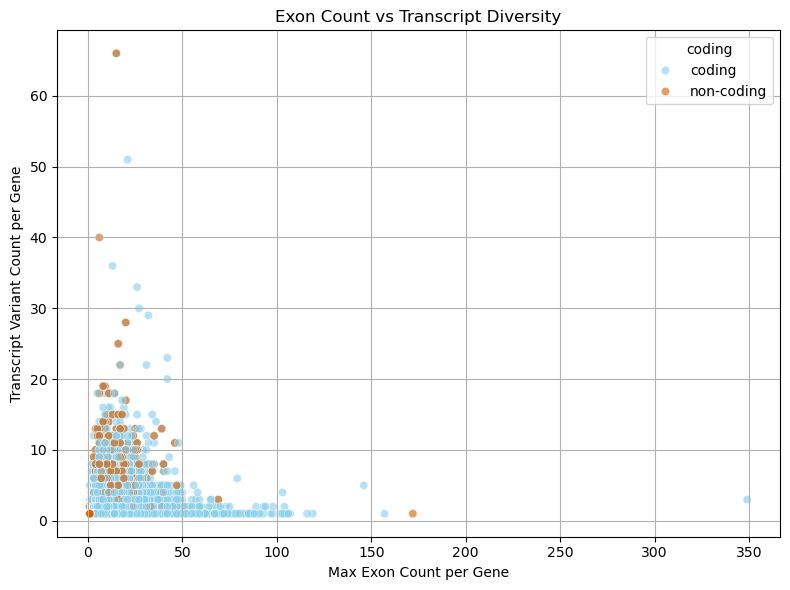

In [88]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=summary,
    x="max_exon_count",
    y="variant_count",
    alpha=0.6,
    hue="coding",
    palette={"coding": "skyblue", "non-coding": "#D55E00"},
)

plt.xlabel("Max Exon Count per Gene")
plt.ylabel("Transcript Variant Count per Gene")
plt.title("Exon Count vs Transcript Diversity")
plt.grid(True)
plt.tight_layout()
plt.show()


- skipped exon, unique exon, a3ss, a5ss, overlapを持つ遺伝子の数を計算

In [98]:
total_genes = data["geneName"].nunique()
print(f"全遺伝子数: {total_genes}")

# （skipped exon）を持つ遺伝子の数をカウント
genes_have_skipped_exon = data[data["exontype"].str.contains("skipped", na=False)]["geneName"].unique()
print(f"skipped exonを持つ遺伝子数: {len(genes_have_skipped_exon)}")
print(f"skipped exonを持たない遺伝子数: {total_genes - len(genes_have_skipped_exon)}")
print(f"skipped exonを持つ遺伝子の割合: {len(genes_have_skipped_exon) / total_genes:.2%}")

#  （unique exon）を持つ遺伝子の数をカウント
genes_have_unique_exon = data[data["exontype"].str.contains("unique", na=False)]["geneName"].unique()
print(f"unique exonを持つ遺伝子数: {len(genes_have_unique_exon)}")
print(f"unique exonを持たない遺伝子数: {total_genes - len(genes_have_unique_exon)}")
print(f"unique exonを持つ遺伝子の割合: {len(genes_have_unique_exon) / total_genes:.2%}")

# 少なくとも（skipped exon）と（unique exon）のいずれかを持つ遺伝子の数をカウント
genes_have_skipped_or_unique_exon = data[
    data["exontype"].str.contains("skipped|unique", na=False)]["geneName"].unique()
print(f"skipped exonまたはunique exonを持つ遺伝子数: {len(genes_have_skipped_or_unique_exon)}")
print(f"skipped exonとunique exonの両方を持たない遺伝子数: {total_genes - len(genes_have_skipped_or_unique_exon)}")
print(f"skipped exonまたはunique exonを持つ遺伝子の割合: {len(genes_have_skipped_or_unique_exon) / total_genes:.2%}")

# (a3ss alternative 3' splice site)を持つ遺伝子の数をカウント
genes_have_a3ss = data[data["exontype"].str.contains("a3ss", na=False)]["geneName"].unique()
print(f"a3ss alternative 3' splice siteを持つ遺伝子数: {len(genes_have_a3ss)}")
print(f"a3ss alternative 3' splice siteを持たない遺伝子数: {total_genes - len(genes_have_a3ss)}")
print(f"a3ss alternative 3' splice siteを持つ遺伝子の割合: {len(genes_have_a3ss) / total_genes:.2%}")

# (a5ss alternative 5' splice site)を持つ遺伝子の数をカウント
genes_have_a5ss = data[data["exontype"].str.contains("a5ss", na=False)]["geneName"].unique()
print(f"a5ss alternative 5' splice siteを持つ遺伝子数: {len(genes_have_a5ss)}")
print(f"a5ss alternative 5' splice siteを持たない遺伝子数: {total_genes - len(genes_have_a5ss)}")
print(f"a5ss alternative 5' splice siteを持つ遺伝子の割合: {len(genes_have_a5ss) / total_genes:.2%}")



全遺伝子数: 26264
skipped exonを持つ遺伝子数: 3064
skipped exonを持たない遺伝子数: 23200
skipped exonを持つ遺伝子の割合: 11.67%
unique exonを持つ遺伝子数: 6502
unique exonを持たない遺伝子数: 19762
unique exonを持つ遺伝子の割合: 24.76%
skipped exonまたはunique exonを持つ遺伝子数: 7509
skipped exonとunique exonの両方を持たない遺伝子数: 18755
skipped exonまたはunique exonを持つ遺伝子の割合: 28.59%
a3ss alternative 3' splice siteを持つ遺伝子数: 3919
a3ss alternative 3' splice siteを持たない遺伝子数: 22345
a3ss alternative 3' splice siteを持つ遺伝子の割合: 14.92%
a5ss alternative 5' splice siteを持つ遺伝子数: 3461
a5ss alternative 5' splice siteを持たない遺伝子数: 22803
a5ss alternative 5' splice siteを持つ遺伝子の割合: 13.18%
